# Grid airborne survey data using different source distributions

**Import useful packages**

In [1]:
from IPython.display import display
from pathlib import Path
import warnings
import numpy as np
import pandas as pd
import xarray as xr
import verde as vd
import matplotlib.pyplot as plt

from boost_and_layouts import (
    combine_parameters,
    save_to_json,
    plot_prediction,
    get_best_prediction,
    predictions_to_datasets,
)


## Define parameters used on the gridding

Let's define all the parameters that will be used on this notebook in the following
cells. These control the results that will be obtain on the rest of the notebook. If
you want to change something (like the interpolation parameters), you can just do it here.

We will avoid hardcoding parameters outside of these few cells in order to facilitate
reproducibility and keep things more organized.

In [2]:
# Define results directory
results_dir = Path("..") / "results"
airborne_results_dir = results_dir / "airborne_survey"

# Define which field will be meassured
field = "g_z"
field_units = "mGal"

# Define set of interpolation parameters
# ======================================
# Define a list of source layouts
layouts = ["source_below_data", "block_averaged_sources", "grid_sources"]
# Define dampings used on every fitting of the gridder
dampings = np.logspace(-4, 2, 7)
# Define depht values
depths = np.arange(1e3, 18e3, 2e3)
# Define parameters for the grid sources:
#    spacing, depth and damping
grid_sources_spacings = [1e3, 2e3, 3e3]
grid_sources_depths = np.arange(1e3, 11e3, 2e3)
grid_sources_dampings = np.logspace(-3, 2, 6)
# Define parameters for variable relative depth layouts:
#    depth factor, depth shift and k_values
depth_factors = [1, 2, 3, 4, 5, 6]
variable_depths = np.arange(50, 1500, 200)
k_values = [1, 5, 10, 15]
# Define block spacing for block averaged sources
block_spacings = np.arange(1e3, 5e3, 1e3)

/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Create dictionary with the parameter values for each source distribution

In [3]:
parameters = {layout: {} for layout in layouts}

# Source below data
layout = "source_below_data"
depth_type = "constant_depth"
parameters[layout][depth_type] = dict(
    depth_type=depth_type, damping=dampings, depth=depths
)

depth_type = "relative_depth"
parameters[layout][depth_type] = dict(
    depth_type=depth_type, damping=dampings, depth=depths
)

depth_type = "variable_depth"
parameters[layout][depth_type] = dict(
    depth_type=depth_type,
    damping=dampings,
    depth_factor=depth_factors,
    depth=variable_depths,
    k_nearest=k_values,
)

# Block-averaged sources
layout = "block_averaged_sources"
depth_type = "constant_depth"
parameters[layout][depth_type] = dict(
    depth_type=depth_type,
    damping=dampings,
    depth=depths,
    spacing=block_spacings,
)

depth_type = "relative_depth"
parameters[layout][depth_type] = dict(
    depth_type=depth_type,
    damping=dampings,
    depth=depths,
    spacing=block_spacings,
)

depth_type = "variable_depth"
parameters[layout][depth_type] = dict(
    depth_type=depth_type,
    damping=dampings,
    spacing=block_spacings,
    depth_factor=depth_factors,
    depth=variable_depths,
    k_nearest=k_values,
)

# Grid sources
depth_type = "constant_depth"
layout = "grid_sources"
parameters[layout][depth_type] = dict(
    depth_type=depth_type,
    damping=grid_sources_dampings,
    depth=grid_sources_depths,
    spacing=grid_sources_spacings,
)

### Dump parameters to a JSON file

In [4]:
json_file = results_dir / "parameters-airborne-survey.json"
save_to_json(parameters, json_file)

### Combine parameter values for each source distribution

Lets create combinations of parameter values for each source distribution

In [5]:
parameters_combined = {layout: {} for layout in layouts}

for layout in parameters:
    for depth_type in parameters[layout]:
        parameters_combined[layout][depth_type] = combine_parameters(
            **parameters[layout][depth_type]
        )

## Read synthetic airborne survey and target grid

Read airborne survey

In [6]:
survey = pd.read_csv(airborne_results_dir / "survey.csv")
survey

,longitude,latitude,height,easting,northing,g_z
0,-0.496429,0.497339,633.0,-55262.223508,54993.627800,3.654625
1,-0.495559,0.497999,644.0,-55165.348426,55066.630053,2.503813
2,-0.493218,0.497479,646.0,-54904.787861,55009.113126,2.873545
3,-0.482725,0.497679,663.0,-53736.719343,55031.235020,3.125810
4,-0.478464,0.497719,672.0,-53262.365493,55035.659399,4.717045
...,...,...,...,...,...,...
5668,-0.416257,0.155824,1070.0,-46337.467390,17230.106636,10.041573
5669,-0.258422,0.271476,1087.0,-28767.445331,30018.377395,15.431621
5670,-0.258652,0.277958,1126.0,-28793.055985,30735.107734,14.078125
5671,-0.258983,0.287360,1106.0,-28829.801706,31774.809862,15.672714


Read target grid

In [7]:
target = xr.open_dataarray(results_dir / "target.nc")
target

/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<xarray.DataArray (northing: 56, easting: 57)>
array([[2.942098, 3.335356, 3.699304, ..., 3.534445, 3.187211, 2.824452],
       [3.334727, 3.805254, 4.23806 , ..., 4.003668, 3.594596, 3.165999],
       [3.697873, 4.237236, 4.731814, ..., 4.442474, 3.976724, 3.488055],
       ...,
       [4.113125, 4.720134, 5.285468, ..., 4.744527, 4.237688, 3.711379],
       [3.717267, 4.247201, 4.740353, ..., 4.301227, 3.852887, 3.387261],
       [3.293559, 3.739541, 4.155882, ..., 3.821831, 3.437721, 3.039456]])
Coordinates:
  * northing  (northing) float64 -5.529e+04 -5.329e+04 ... 5.271e+04 5.471e+04
  * easting   (easting) float64 -5.566e+04 -5.366e+04 ... 5.434e+04 5.634e+04
Attributes:
    height:   2000

Define coordiantes tuple with the location of the survey points

In [8]:
coordinates = (survey.easting.values, survey.northing.values, survey.height.values)

## Grid data using different source layouts

Let's grid the synthetic data using the Equivalent Layer method using different source
layouts. For each layout we will perform several interpolations, one for each set of
parameters, score each prediction against the target data and get the best one.

We will finally compare the performance of each source layout based on the best
prediction produce by each of them.

## Score each interpolation

In [9]:
rms = {layout: {} for layout in layouts}
best_predictions = []

for layout in layouts:
    for depth_type in parameters_combined[layout]:
        with warnings.catch_warnings():
            # Disable warnings
            # (we expect some warnings due to
            # underdetermined problems on grid layouts)
            warnings.simplefilter("ignore")
            print("Processing: {} with {}".format(layout, depth_type))
            best_prediction, params_and_rms = get_best_prediction(
                coordinates,
                getattr(survey, field).values,
                target,
                layout,
                parameters_combined[layout][depth_type],
            )
            best_predictions.append(best_prediction)
            rms[layout][depth_type] = params_and_rms

# Group best predictions into datasets
best_predictions = predictions_to_datasets(best_predictions)

Processing: source_below_data with constant_depth
Processing: source_below_data with relative_depth
Processing: source_below_data with variable_depth
Processing: block_averaged_sources with constant_depth
Processing: block_averaged_sources with relative_depth
Processing: block_averaged_sources with variable_depth
Processing: grid_sources with constant_depth


In [10]:
for prediction in best_predictions:
    display(prediction)

/home/santi/miniconda3/envs/eql-gradient-boosted/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<xarray.Dataset>
Dimensions:         (easting: 57, northing: 56)
Coordinates:
  * easting         (easting) float64 -5.566e+04 -5.366e+04 ... 5.634e+04
  * northing        (northing) float64 -5.529e+04 -5.329e+04 ... 5.471e+04
    upward          (northing, easting) float64 2e+03 2e+03 ... 2e+03 2e+03
Data variables:
    constant_depth  (northing, easting) float64 3.128 3.759 ... 3.939 3.611
    relative_depth  (northing, easting) float64 3.494 3.797 ... 3.887 3.514
    variable_depth  (northing, easting) float64 3.511 3.951 ... 4.145 3.816
Attributes:
    layout:   source_below_data

<xarray.Dataset>
Dimensions:         (easting: 57, northing: 56)
Coordinates:
  * easting         (easting) float64 -5.566e+04 -5.366e+04 ... 5.634e+04
  * northing        (northing) float64 -5.529e+04 -5.329e+04 ... 5.471e+04
    upward          (northing, easting) float64 2e+03 2e+03 ... 2e+03 2e+03
Data variables:
    constant_depth  (northing, easting) float64 3.081 3.687 ... 3.895 3.531
    relative_depth  (northing, easting) float64 3.439 3.808 4.214 ... 3.848 3.44
    variable_depth  (northing, easting) float64 3.337 3.622 3.958 ... 3.615 3.13
Attributes:
    layout:   block_averaged_sources

<xarray.Dataset>
Dimensions:         (easting: 57, northing: 56)
Coordinates:
  * easting         (easting) float64 -5.566e+04 -5.366e+04 ... 5.634e+04
  * northing        (northing) float64 -5.529e+04 -5.329e+04 ... 5.471e+04
    upward          (northing, easting) float64 2e+03 2e+03 ... 2e+03 2e+03
Data variables:
    constant_depth  (northing, easting) float64 2.149 2.907 ... 3.887 3.559
Attributes:
    layout:   grid_sources

### Save best predictions

In [11]:
for dataset in best_predictions:
    dataset.to_netcdf(
        airborne_results_dir / "best_predictions-{}.nc".format(dataset.layout)
    )

## Plot best predictions

source_below_data with constant_depth
RMS: 0.345795789141974
Number of sources: 5673
Parameters: {'metadata': 'Generated by EQLHarmonic(damping=0.01,\n            points=(array([-55262.22350838, -55165.34842636, -54904.78786095, ...,\n       -28793.055985  , -28829.80170576, -10178.56465152]),\n                    array([54993.62780034, 55066.63005294, 55009.11312603, ...,\n       30735.10773362, 31774.80986191, 24142.97215835]),\n                    array([-6641., -6641., -6641., ..., -6641., -6641., -6641.])))', 'depth_type': 'constant_depth', 'damping': 0.01, 'depth': 7000.0, 'layout': 'source_below_data', 'rms': 0.345795789141974, 'n_points': 5673}


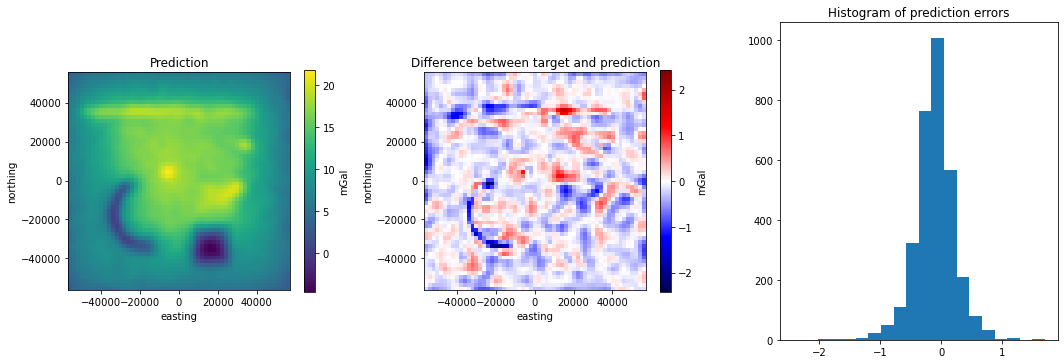

source_below_data with relative_depth
RMS: 0.3466577308770337
Number of sources: 5673
Parameters: {'metadata': 'Generated by EQLHarmonic(damping=0.01,\n            points=(array([-55262.22350838, -55165.34842636, -54904.78786095, ...,\n       -28793.055985  , -28829.80170576, -10178.56465152]),\n                    array([54993.62780034, 55066.63005294, 55009.11312603, ...,\n       30735.10773362, 31774.80986191, 24142.97215835]),\n                    array([-8367., -8356., -8354., ..., -7874., -7894., -7944.])))', 'depth_type': 'relative_depth', 'damping': 0.01, 'depth': 9000.0, 'layout': 'source_below_data', 'rms': 0.3466577308770337, 'n_points': 5673}


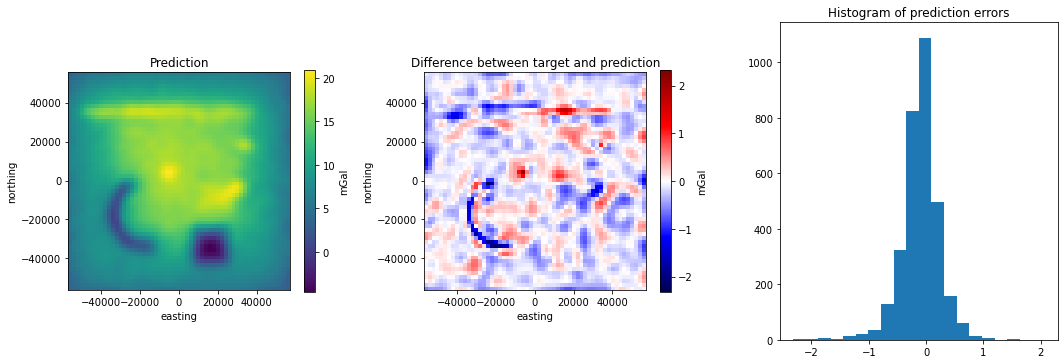

source_below_data with variable_depth
RMS: 0.3609972477976416
Number of sources: 5673
Parameters: {'metadata': 'Generated by EQLHarmonic(damping=1.0,\n            points=(array([-55262.22350838, -55165.34842636, -54904.78786095, ...,\n       -28793.055985  , -28829.80170576, -10178.56465152]),\n                    array([54993.62780034, 55066.63005294, 55009.11312603, ...,\n       30735.10773362, 31774.80986191, 24142.97215835]),\n                    array([-2817.29966131, -2709.23493668, -2446.63688555, ...,\n       -2309.16808525, -2101.53899775, -2248.93699744])))', 'depth_type': 'variable_depth', 'damping': 1.0, 'depth_factor': 1, 'depth': 1450, 'k_nearest': 15, 'layout': 'source_below_data', 'rms': 0.3609972477976416, 'n_points': 5673}


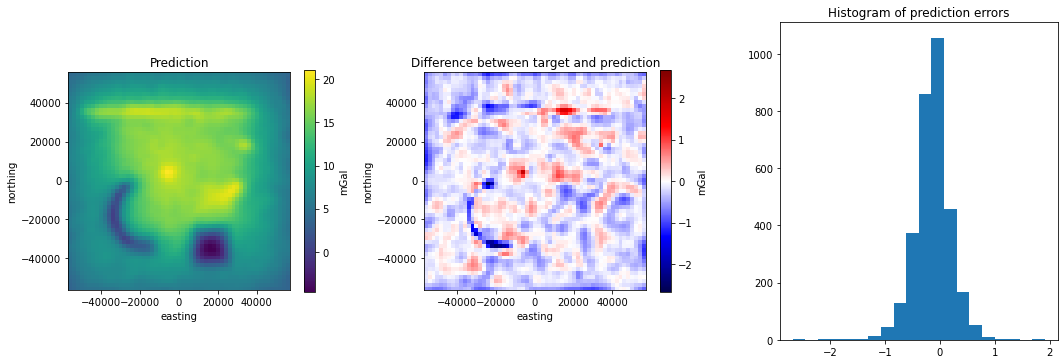

block_averaged_sources with constant_depth
RMS: 0.34342345493718107
Number of sources: 1100
Parameters: {'metadata': 'Generated by EQLHarmonic(damping=0.0001,\n            points=(array([-54805.12901221, -50713.54868052, -49164.660875  , ...,\n        48224.30447546,  51776.94756928,  52779.10359011]),\n                    array([-52654.24129662, -52491.64591387, -52378.82464708, ...,\n        55083.2214754 ,  55221.48334059,  55287.84904553]),\n                    array([-8641., -8641., -8641., ..., -8641., -8641., -8641.])))', 'depth_type': 'constant_depth', 'damping': 0.0001, 'depth': 9000.0, 'spacing': 3000.0, 'layout': 'block_averaged_sources', 'rms': 0.34342345493718107, 'n_points': 1100}


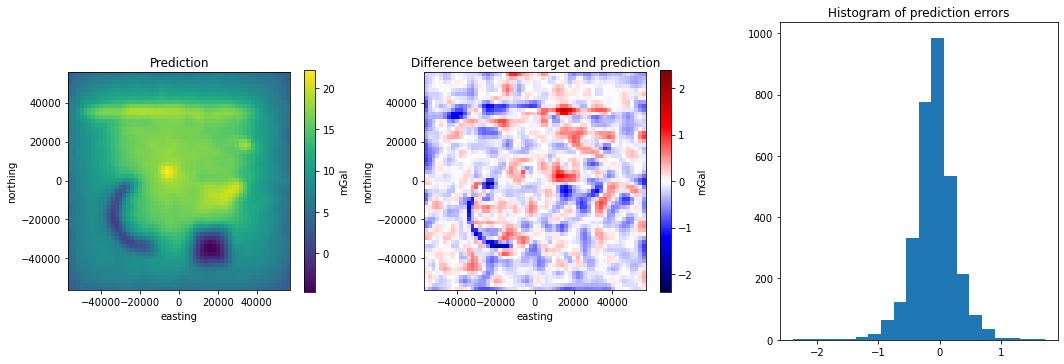

block_averaged_sources with relative_depth
RMS: 0.3444410231429399
Number of sources: 1663
Parameters: {'metadata': 'Generated by EQLHarmonic(damping=0.001,\n            points=(array([-43594.90041259, -34322.73020658, -33155.77519566, ...,\n        49190.82828221,  50368.36160668,  52304.74974025]),\n                    array([-54440.58067174, -55199.36144031, -55016.85579029, ...,\n        55110.87384602,  55157.32983166,  55283.42466501]),\n                    array([-8635., -8553., -8600., ..., -8076., -7963., -7890.])))', 'depth_type': 'relative_depth', 'damping': 0.001, 'depth': 9000.0, 'spacing': 2000.0, 'layout': 'block_averaged_sources', 'rms': 0.3444410231429399, 'n_points': 1663}


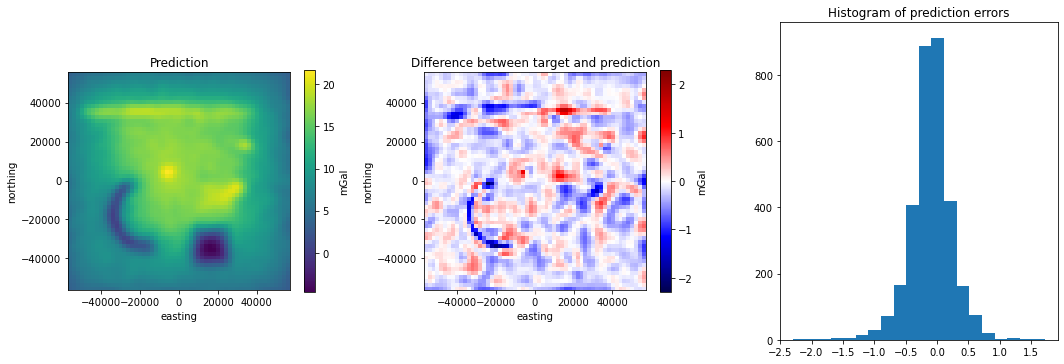

block_averaged_sources with variable_depth
RMS: 0.3254223411594151
Number of sources: 1663
Parameters: {'metadata': 'Generated by EQLHarmonic(damping=0.01,\n            points=(array([-43594.90041259, -34322.73020658, -33155.77519566, ...,\n        49190.82828221,  50368.36160668,  52304.74974025]),\n                    array([-54440.58067174, -55199.36144031, -55016.85579029, ...,\n        55110.87384602,  55157.32983166,  55283.42466501]),\n                    array([-12462.13759579, -12837.69220832, -12105.38471891, ...,\n        -9601.7502509 ,  -9769.77986637, -10000.15008929])))', 'depth_type': 'variable_depth', 'damping': 0.01, 'spacing': 2000.0, 'depth_factor': 2, 'depth': 50, 'k_nearest': 15, 'layout': 'block_averaged_sources', 'rms': 0.3254223411594151, 'n_points': 1663}


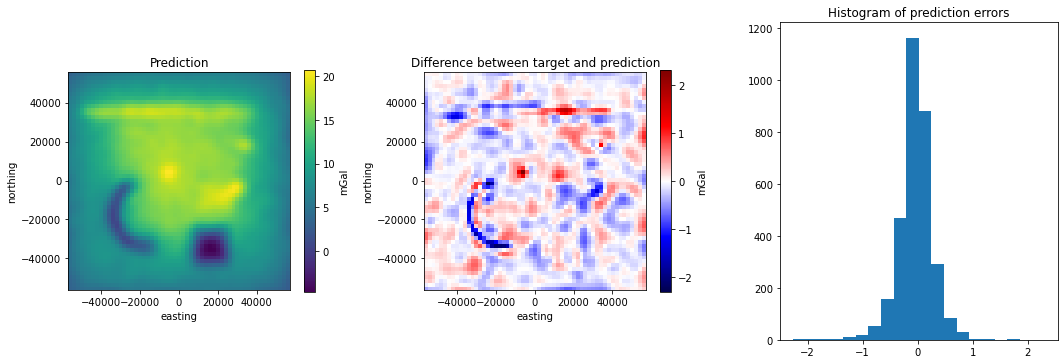

grid_sources with constant_depth
RMS: 0.3429560528004137
Number of sources: 12544
Parameters: {'metadata': 'Generated by EQLHarmonic(damping=0.1,\n            points=(array([[-55659.74539664, -54656.8671012 , -53653.98880577, ...,\n         53653.98880577,  54656.8671012 ,  55659.74539664],\n       [-55659.74539664, -54656.8671012 , -53653.98880577, ...,\n         53653.98880577,  54656.8671012 ,  55659.74539664],\n       [-55659.74539664, -54656.8671012 , -53653.98880577, ...,\n         53653.98880577,  54656.8671012 ,  55659.74539664],\n       ...,\n       [-55659.74539664...\n         55287.84904553,  55287.84904553,  55287.84904553]]),\n                    array([[-6641., -6641., -6641., ..., -6641., -6641., -6641.],\n       [-6641., -6641., -6641., ..., -6641., -6641., -6641.],\n       [-6641., -6641., -6641., ..., -6641., -6641., -6641.],\n       ...,\n       [-6641., -6641., -6641., ..., -6641., -6641., -6641.],\n       [-6641., -6641., -6641., ..., -6641., -6641., -6641.],\n   

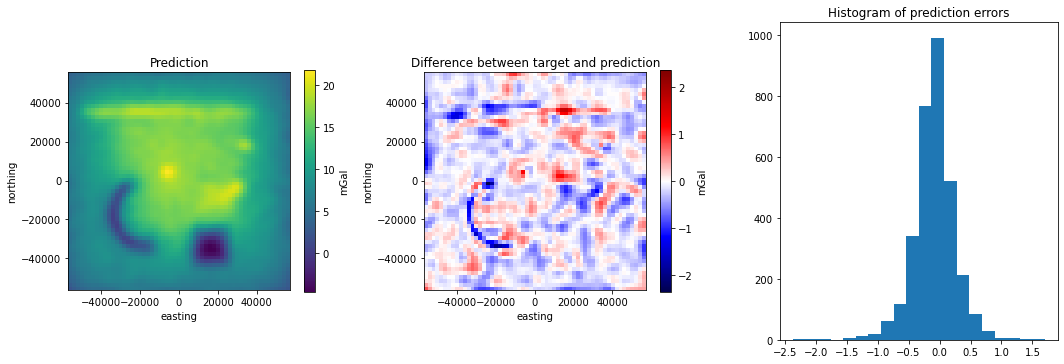

In [12]:
for dataset in best_predictions:
    for depth_type in dataset:
        layout = dataset.layout
        prediction = dataset[depth_type]
        print("{} with {}".format(layout, depth_type))
        print("RMS: {}".format(prediction.rms))
        print("Number of sources: {}".format(prediction.n_points))
        print("Parameters: {}".format(prediction.attrs))
        plot_prediction(prediction, target, units=field_units)

## Plot and compare all best predictions

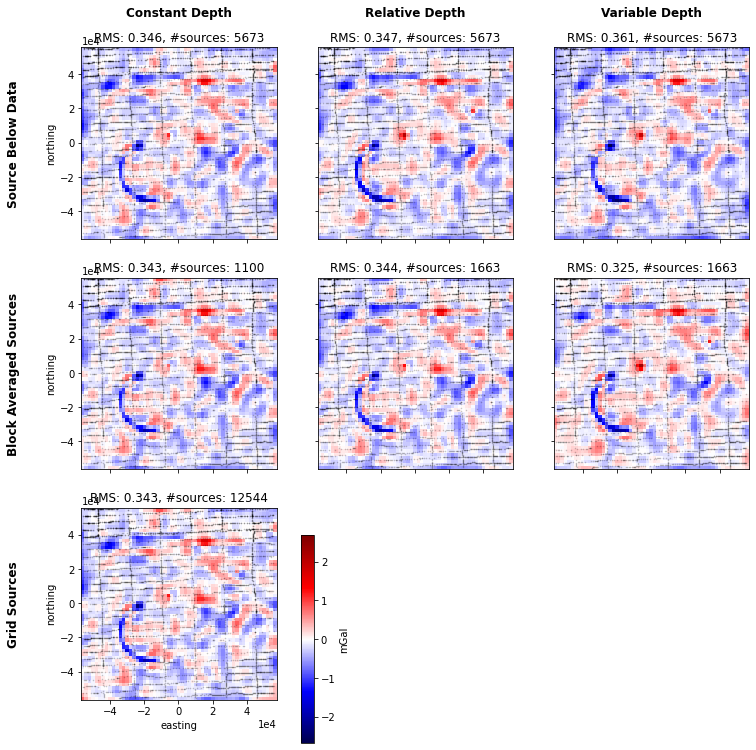

In [13]:
vmax = vd.maxabs(
    *list(
        target - dataset[depth_type]
        for dataset in best_predictions
        for depth_type in dataset
    )
)

# Initialize figure
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12), sharex=True, sharey=True)

for i, (ax_row, dataset) in enumerate(zip(axes, best_predictions)):
    for j, (ax, depth_type) in enumerate(zip(ax_row, dataset)):
        prediction = dataset[depth_type]
        difference = target - prediction
        tmp = difference.plot.pcolormesh(
            ax=ax,
            vmin=-vmax,
            vmax=vmax,
            cmap="seismic",
            add_colorbar=False,
        )
        ax.scatter(survey.easting, survey.northing, s=0.3, alpha=0.2, color="k")
        ax.set_aspect("equal")
        # Set scientific notation on axis labels (and change offset text position)
        ax.ticklabel_format(axis="both", style="sci", scilimits=(0, 0))
        # Set title with RMS and number of points
        ax.set_title(
            "RMS: {:.3f}, #sources: {}".format(prediction.rms, prediction.n_points),
            horizontalalignment="center",
        )

        # Annotate the columns of the figure
        if i == 0:
            ax.text(
                0.5,
                1.16,
                depth_type.replace("_", " ").title(),
                fontsize="large",
                fontweight="bold",
                horizontalalignment="center",
                transform=ax.transAxes,
            )
        # Annotate the rows of the figure
        if j == 0:
            ax.text(
                -0.38,
                0.5,
                dataset.layout.replace("_", " ").title(),
                fontsize="large",
                fontweight="bold",
                verticalalignment="center",
                rotation="vertical",
                transform=ax.transAxes,
            )
        # Remove xlabels and ylabels from inner axes
        if i != 2:
            ax.set_xlabel("")
        if j != 0:
            ax.set_ylabel("")

# Hide the last two axes because they are not used
axes[-1][-1].set_visible(False)
axes[-1][-2].set_visible(False)

# Add colorbar
cbar_ax = fig.add_axes([0.38, 0.075, 0.015, 0.24])
fig.colorbar(tmp, cax=cbar_ax, orientation="vertical", label=field_units)

plt.show()